# DSI37 Capstone Project: Skin Disease Classification Using Computer Vision

<a id='part_iii'></a>
[Part I](Part1-Intro_Eda.ipynb#part_i) <br>
[Part II](Part2-EfficientnetModel.ipynb#part_ii) <br>
[Part III](Part3-VggModel.ipynb#part_iii) <br>
[Part IV](Part4-ResnetModel.ipynb#part_iv)

<a id='part_v'></a>
# Part 5: Ensemble Model, Insights and Recommendations

## Contents
[1. Importing Libraries](#imports) <br>
[2. Importing and Preprocessing Data](#data) <br>
[3. Ensemble Model](#ensemble) <br>
[4. Insights](#insights) <br>
[5. Challenges](#challenges) <br>
[6. Conclusion](#conclusion) <br>
[7. Recommendations](#recommendations) <br>

<a id='imports'></a>
## 1. Importing Libraries

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from IPython.display import Image, display
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

<a id='data'></a>
## 2. Importing and Preprocessing Data

In [ ]:
# Setting directories
cwd = '/content/drive/MyDrive/Colab Notebooks/Capstone 3'
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/data'
model_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/models'

In [ ]:
# Setting batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Creating train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Creating validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 3265 files belonging to 5 classes.
Using 2612 files for training.
Found 3265 files belonging to 5 classes.
Using 653 files for validation.


In [ ]:
# Get the class labels and number of classes from the dataset
class_labels = train_ds.class_names
num_classes = len(class_labels)
print('Class labels:', class_labels)
print("Number of classes:", num_classes)

# Create the inverse mapping of class indices to class labels
inv_map_classes = {i: label for i, label in enumerate(class_labels)}
map_classes = {label: i for i, label in enumerate(class_labels)}
print('Inverse mapping of classes:', inv_map_classes)
print('Mapping of classes:', map_classes)

Class labels: ['acne', 'eczema', 'fungal', 'psoriasis', 'warts']
Number of classes: 5
Inverse mapping of classes: {0: 'acne', 1: 'eczema', 2: 'fungal', 3: 'psoriasis', 4: 'warts'}
Mapping of classes: {'acne': 0, 'eczema': 1, 'fungal': 2, 'psoriasis': 3, 'warts': 4}


In [ ]:
# Creating test dataset
val_batches = val_ds.cardinality()
test_ds = val_ds.take(val_batches // 5) # Moving 20% into test dataset
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % val_ds.cardinality())
print('Number of test batches: %d' % test_ds.cardinality())

Number of validation batches: 17
Number of test batches: 4


In [ ]:
# Prepare all train/validation/test datasets
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<a id='ensemble'></a>
## 3. Ensemble Model

In [ ]:
# Loading models
vgg_model = keras.models.load_model(os.path.join(model_dir, 'vgg_fine.h5'))
res_model = keras.models.load_model(os.path.join(model_dir, 'res_fine.h5'))
eff_model = keras.models.load_model(os.path.join(model_dir, 'eff_fine2.h5'))

In [ ]:
# Quick check on test accuracies
vgg_test_acc = vgg_model.evaluate(test_ds)
res_test_acc = res_model.evaluate(test_ds)
eff_test_acc = eff_model.evaluate(test_ds)
print('Test Accuracy (VGG): {:.2f}'.format(vgg_test_acc[1]))
print('Test Accuracy (ResNet): {:.2f}'.format(res_test_acc[1]))
print('Test Accuracy (EffNet): {:.2f}'.format(eff_test_acc[1]))

4/4 [==============================] - 10s 349ms/step - loss: 0.3605 - accuracy: 0.8828
Test Accuracy (VGG): 0.85
Test Accuracy (ResNet): 0.83
Test Accuracy (EffNet): 0.88


In [ ]:
# Define ensemble model
def ensemble_model(model_list, test_data):
  """This function/model takes 2 inputs, and return the label(s) with the highest combined probability
  model_list (list) is a list of trained models you want to use for the ensemble
  test_data (tf.data.dataset) is the dataset you want to predict using the ensemble model
  """
  y_preds = [model.predict(test_data, verbose=0) for model in model_list]
  # Sum across ensemble members, shape of (128, 5), each row sums up to 3
  summed = np.sum(y_preds, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return result

In [ ]:
# Create list of models
models = [vgg_model, res_model, eff_model]

In [ ]:
# Generate predictions and labels for train dataset
train_labels =  []
train_preds = []
for image, label in train_ds.unbatch():
  image = np.expand_dims(image, 0)
  prediction = ensemble_model(models, image)
  train_preds.append(prediction)
  train_labels.append(np.argmax(label))

ensemble_train_acc = accuracy_score(train_labels, train_preds)

In [ ]:
# Generate predictions and labels for test dataset
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  image = np.expand_dims(image, 0)
  prediction = ensemble_model(models, image)
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

ensemble_test_acc = accuracy_score(test_labels, test_preds)

In [ ]:
# Print ensemble model train and test accuracy
print('Ensemble Model Train Accuracy: {:.2f}'.format(ensemble_train_acc))
print('Ensemble Model Test Accuracy: {:.2f}'.format(ensemble_test_acc))

Ensemble Model Train Accuracy: 0.99
Ensemble Model Test Accuracy: 0.90


In [ ]:
# Classification Report for Ensemble Model
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00        10
      eczema       0.82      0.92      0.87        39
      fungal       0.91      0.94      0.92        32
   psoriasis       1.00      0.75      0.86        28
       warts       0.90      0.95      0.92        19

    accuracy                           0.90       128
   macro avg       0.93      0.91      0.91       128
weighted avg       0.91      0.90      0.90       128



In [ ]:
# Defining function to plot confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title):
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=True)

    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

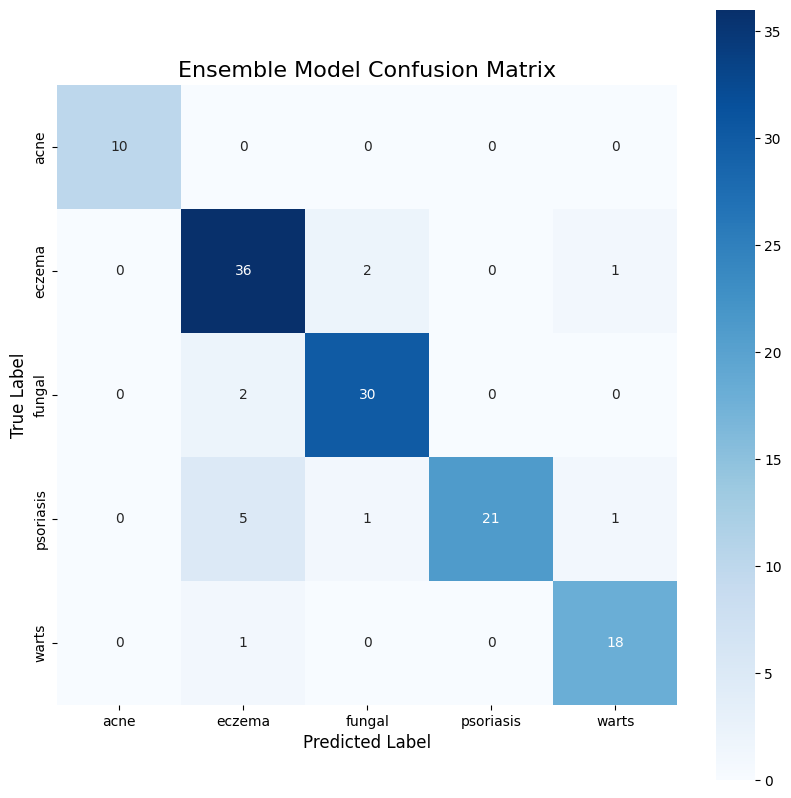

In [ ]:
# Confusion Matrix for Ensemble Model
plot_heatmap(test_labels, test_preds, class_labels, title="Ensemble Model Confusion Matrix")

<a id='insights'></a>
## 4. Insights

### Models Summary

|Model|Train Accuracy|Test Accuracy|
|:---|:---:|:---|
|<b>EfficientNetV2L</b>|0.89|0.78|
|<b>EfficientNetV2L Fine-Tuned</b>|0.93|0.88|
|<b>VGG16</b>|0.96|0.81|
|<b>VGG16 Fine-Tuned|0.99|0.85|
|<b>ResNet152V2</b>|0.91|0.80|
|<b>ResNet152V2 Fine-Tuned|0.98|0.82|
|<b>Ensemble Model|0.99|0.90|

### Model Architectures

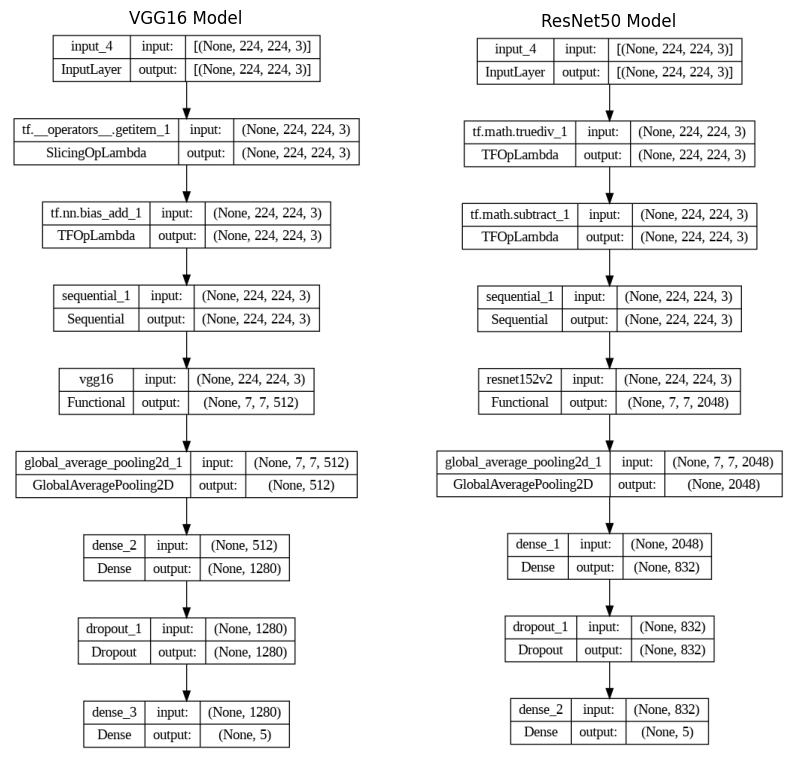

In [ ]:
# Skip efficientnet architecture as it is too long
# Plot the VGG16 model on the first subplot
plt.figure(figsize=(10,10))

plt.subplot(121)
plot_model(vgg_model, show_shapes=True, to_file='vgg_model.png')
plt.imshow(plt.imread('vgg_model.png'))
plt.axis('off')
plt.title('VGG16 Model')

# Plot the ResNet50 model on the second subplot
plt.subplot(122)
plot_model(res_model, show_shapes=True, to_file='res_model.png')
plt.imshow(plt.imread('res_model.png'))
plt.axis('off')
plt.title('ResNet50 Model')

# Show the plot
plt.show()

### Grad-CAM

In [ ]:
def get_img_array(test_ds, size):
    test_ds = test_ds.shuffle(1000)
    for image, label in test_ds.unbatch():
      array = keras.utils.img_to_array(image)
      array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = img_array[0]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = colormaps['jet']

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

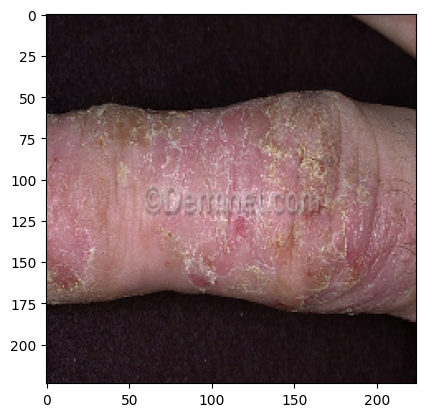

In [ ]:
# Set image size
img_size = (224, 224)

# Get image array
img_array = get_img_array(test_ds, img_size)

# Name of last convolutional layer in EfficientNetV2L
last_conv_layer_name = "top_conv"

# Show image
plt.imshow(keras.utils.array_to_img(img_array[0]))

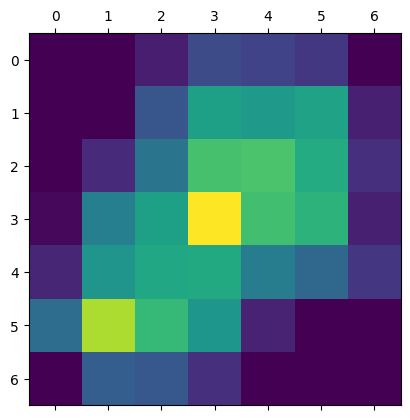

In [ ]:
# Remove last layer's softmax
eff_model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, eff_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

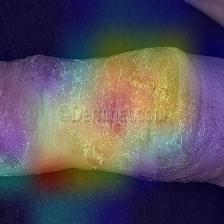

In [ ]:
# Display superimposed heatmap
save_and_display_gradcam(img_array, heatmap)

### Examples of Wrongly Predicted Images

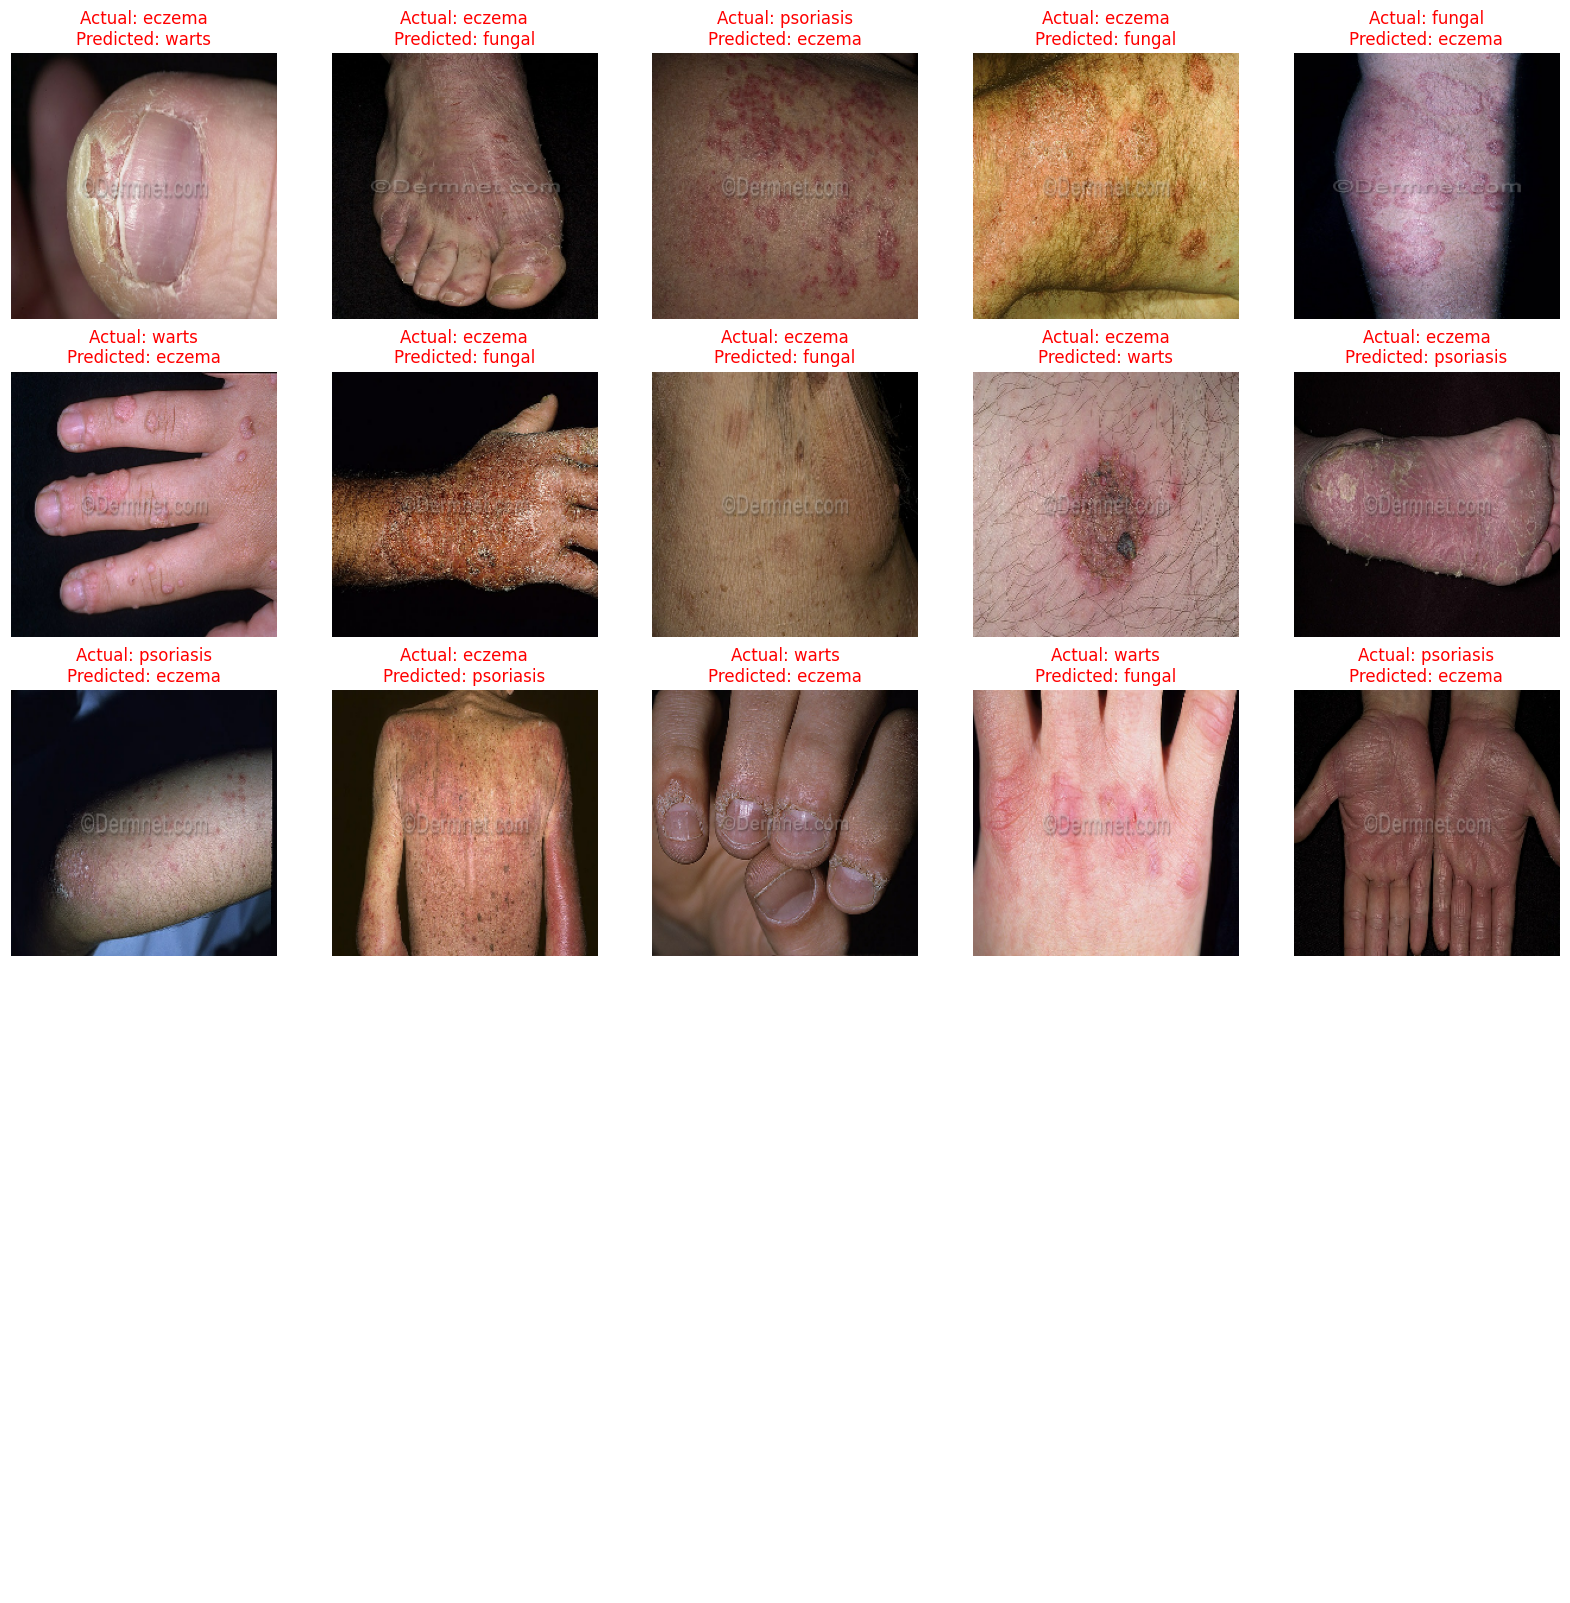

In [ ]:
# Viewing misclassified images
fig, axes = plt.subplots(5, 5, figsize=(20,20))
axes = axes.reshape(-1)
axoff = np.vectorize(lambda ax: ax.axis('off'))
axoff(axes)
ax = 0
misclassified_files = []
for image, label in test_ds.unbatch():
  batched_image = np.expand_dims(image, 0)
  comb_pred = ensemble_model(models, batched_image)[0]
  true_label = np.argmax(label)
  if true_label != comb_pred:
    true_class = inv_map_classes[true_label]
    pred_class = inv_map_classes[comb_pred]
    title = 'Actual: ' + true_class + '\nPredicted: ' + pred_class
    image = image.numpy()
    axes[ax].set_title(title, color='red')
    axes[ax].imshow(image.astype(np.uint8))
    ax += 1

- The most common misclassification is between psoriasis, eczema and fungal infections.

<a id='challenges'></a>
## 5. Challenges
- Overfitting was very difficult to tackle. When training most models, the train accuracy would be at least 10-15% more than the validation accuracy. There are a few ways to try to overcome overfitting, including dropouts, regularization, simplifying model architecture, and to use data augmentation. Regularization was not possible because I was using transfer learning. When implementing data augmentation, dropouts and simplification of model architecture, the model was underfitting in most cases, as seen in the hypertuning where the train accuracy was < 60-70% in a lot of cases. I used a combination of all 3 of the techniques, in addition to using an ensemble model to decrease variance. The end result would be a 9% difference between train and test accuracy, which is significantly better than most of the individual models.

- Fine-tuning has the potential to boost the models' accuracies significantly, approximately 5-10%, but also runs a huge risk of causing the model to overfit. I had to do multiple trials of freezing different number of blocks to find the optimal tradeoff between decreasing bias or increasing variance.

<a id='conclusion'></a>
## 6. Conclusion

**The model is accurate and can serve as a reliable tool for preliminary diagnosis of skin conditions**
- The developed image classification model has demonstrated remarkable accuracy, achieving 99% accuracy on the training dataset and 90% accuracy on the testing dataset. It has also achieved >90% on other metrics such as f1-score, recall and precision.
- This high level of accuracy indicates the model's effectiveness in accurately classifying common skin diseases.

**Fungal rashes, eczema and psoriasis are more difficult to differentiate**
- For all models, the recall and f1-score is consistently the lowest for psoriasis. This is expected as psoriasis presents with a wide range of clinical features and has many different subtypes. For example, guttate psoriasis may be misclassified as acne, whereas thick scaly lesions in plaque psoriasis may be misclassified as eczema.
- The higher recall and f1-score achieved for acne and warts in the skin disease classification model suggest that these conditions are relatively easier to classify accurately. One plausible explanation for this observation is that acne and warts are often more localized in nature compared to other skin conditions. For instance, in the case of acne, it commonly appears as individual pimples or lesions, occurring one at a time or in small clusters. This localized nature may result in distinct visual patterns that are easier for the model to recognize and classify correctly. Similarly, warts usually tend to be isolated rather than occurring in large clusters. This characteristic makes it easier for the model to distinguish warts from other skin conditions that may present with a more diffuse or widespread appearance.
- On the other hand, skin conditions like eczema may manifest as broader and more extensive areas of inflammation and irritation, often with multiple patches or lesions close together. The complexity and variation in presentation for such conditions might pose a greater challenge for the model's classification performance.


In conclusion, the project successfully developed an accurate image classification model and implemented it in a user-friendly application/website. This comprehensive solution provides individuals with the means to obtain reliable preliminary diagnoses, access pertinent information about their skin conditions, and explore self-treatment options for common skin ailments. It has the potential to reduce the strain on clinics, minimize waiting times, and empower individuals to take control of their skin health. The project offers a valuable contribution towards improving healthcare accessibility and management of self-treatable skin conditions.

<a id='recommendations'></a>
## 7. Recommendations

**1. One-stop solution for self-treatable skin conditions**
- The model can be incorporated into an application to serve as a one-stop solution for patients with self-treatable skin conditions.
- The model serves as a reliable tool for individuals seeking a preliminary diagnosis for their skin conditions. By capturing and uploading images of their ailments, users can receive prompt and accurate identification of their skin disease.
- The application can then provide pertinent information to the patient regarding his/her disease, including what a brief description of the condition, example images, disease course, management, lifestyle tips, and medications for self-treatment.
- The proposed solution will provide a holistic and seamless experience for patients, sparing them from the hassle of seeking information from multiple internet sources, encountering conflicting advice, and receiving varying medication recommendations. By integrating the model's reliable diagnosis and comprehensive information about their skin condition, patients can access all the necessary resources in one place, ensuring they receive accurate guidance on disease management, suitable medications, and where to obtain them.

**2. Integration with telemedicine and collaboration with dermatologists**
- Integrating telemedicine features with my proposed solution is a logical step that would truly benefit patients and our healthcare system.
- Telemedicine can allow users to consult with dermatologists remotely. This feature can provide an additional layer of support by offering virtual consultations, advice, and guidance for more complex or non-self-treatable skin conditions like psoriasis. This would also be beneficial for patients who are less confident with the initial preliminary diagnosis or have not benefited from self-treatment after a certain time period.
- Collaboration with dermatology clinics or medical institutions can help facilitate this telemedicine aspect and provide users with a more holistic healthcare experience. Integration with medication delivery service would also be useful as this means patients can receive the entire healthcare package without stepping out of their houses.

**3. Expansion of dataset and continuous model improvement**
- To enhance the model's generalization capabilities especially in the local context, it is recommended to expand the dataset by including a larger proportion of skin images originating from Singaporean patients.
- Collaborating with healthcare professionals or institutions to gather diverse and representative data can help capture a comprehensive spectrum of skin conditions prevalent in Singapore. Additionally, considering variations in age, gender, and ethnicity within the dataset can improve the model's accuracy across different populations.
- Image segmentation techniques can be explored to focus on targeted skin regions. This can potentially increase the model accuracy and enable the model to detect mixed skin lesions.
- Multi-label, multi-output algorithms can be explored. For example, the model can be trained to detect specific subtypes of fungal skin infections, such as candidiasis, which requires different treatment.